In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt
from typing import *

Function = Callable[[np.array], float]

#### Функция вычисления градиента функции

In [2]:
def gradient(f: Function, x: np.array) -> np.array:
    delta = 1e-5
    result = np.zeros(x.size)
    for i in range(x.size):
        new_x = x
        new_x[i] += delta / 2
        f0 = f(new_x)
        new_x[i] -= delta
        f1 = f(new_x)
        result[i] = (f0 - f1) / delta
    return result

#### Градиентный спуск

In [3]:
def gradient_descent(f: Function, x: np.array, steps: int, lr: float) -> np.array:
    points = np.zeros((steps, x.size))
    points[0] = x

    for i in range(1, steps):
        x -= lr * gradient(f, x)
        points[i] = x
        if np.linalg.norm(gradient(f, x), len(x)) < 1e-5:
          break

    return points

#### Функция для рисования процесса градиентного спуска

In [4]:
def draw_gradient(f: Function, points: np.array) -> None:
    plt.plot(points[:, 0], points[:, 1], color='c')
    t = np.linspace(-5, 10, 100)
    x, y = np.meshgrid(t, t)
    plt.contourf(x, y, f(np.array([x, y])), levels=sorted(set(f(p) for p in points)))

#### Функция для тестирования градиентного спуска

In [5]:
def f(x: np.array) -> float:
    return (x[0] + 2) ** 2 + (x[1] - 3) ** 4 - 10

#### Сходимость при $lr = 0.05$

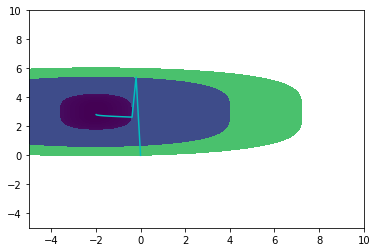

In [6]:
draw_gradient(f,gradient_descent(f, np.zeros(2), 50, 0.05))

#### Сходимость при $lr = 0.03$

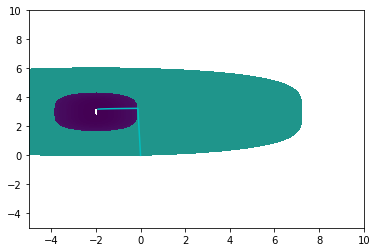

In [7]:
draw_gradient(f,gradient_descent(f, np.zeros(2), 50, 0.03))

#### Градиентный спуск с экспоненциальной фукнцией изменения шага

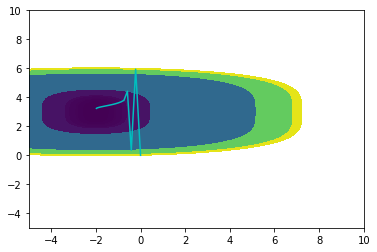

In [8]:
def gradient_exp_descent(f: Function, x: np.array, steps: int, lr0: float, d: float) -> np.array:
    points = np.zeros((steps, x.size))
    points[0], lr = x, lr0

    for i in range(1, steps):
        x -= lr * gradient(f, x)
        lr = lr0 * math.exp(-d * i)
        points[i] = x

    return points


points = gradient_exp_descent(f, np.zeros(2), 40, 0.055, 0.001)
draw_gradient(f, points)

#### Одномерный поиск

In [9]:
def dichotomy(f: Function, l: float, r: float) -> np.array:
    delta = 1e-5
    counter = 0

    while r - l > 2 * delta:
        m = (r + l) / 2
        x1, x2 = m - delta / 2, m + delta / 2
        if f(x1) <= f(x2):
            r = m
        else:
            l = m
        counter += 1
    print(counter)
    return l

# |-----|---|-----|
# l    n_l n_r    r
def golden_ratio_search(f: Function, l: float, r: float, eps: float):
    phi = (1 + np.sqrt(5)) / 2
    d = (r - l) / phi
    next_l, next_r = r - d, l + d
    f_next_l, f_next_r = f(next_l), f(next_r)
    counter = 0

    while r - l > eps:
        if f_next_l <= f_next_r:
            # new section is (l, next_r)
            r = next_r
            next_r = next_l
            f_next_r = f_next_l
            next_l = r - (r - l) / phi
            f_next_l = f(next_l)
        else:
            # new section is (next_l, r)
            l = next_l
            next_l = next_r
            f_next_l = f_next_r
            next_r = l + (r - l) / phi
            f_next_r = f(next_r)
        counter += 1
    print(counter)
    return (l + r) / 2

In [10]:
print(dichotomy(lambda x: math.sin(math.cos(x)), -4, 4))
print(golden_ratio_search(lambda x: math.sin(math.cos(x)), -4, 4, 0.00001))
e = math.e
print(golden_ratio_search(lambda x: math.log(e ** (x + 2) - e ** (-x), e), -1, 10, 0.00001))
print(golden_ratio_search(lambda x: math.sin(x + x ** 2 - 1) - math.cos(x ** 2) / 2, -6, -1, 0.00001))
print(golden_ratio_search(lambda x: x - (2 * x + 1) * e ** math.cos(-x ** 3 - x + 1), -2, 3, 0.00001))

19
-3.1416015625
29
-3.141594788214058
29
-0.9999952167715643
28
-2.8039599779252264
28
2.2465430530951234


### Одномерный спуск с учётом условий Вольфе

In [11]:
# First condition, c_1 is pretty small
def wolfe_1(alpha, f, grad, x):
    c_1 = 1e-4
    return f(alpha) <= f(0) + c_1 * alpha * -grad(x).dot(grad(x))


# Second condition, c_2 should be as close to 1 as possible
def wolfe_2(alpha, grad, x):
    c_2 = 1 - 1e-4
    return -grad(x).dot(grad(x - alpha * grad(x))) >= c_2 * -grad(x).dot(grad(x))


def golden_section_wolfe(f: Function, grad: Function, x, l: float, r: float, eps: float) -> float:
    phi = (1 + np.sqrt(5)) / 2
    d = (r - l) / phi
    next_l, next_r = r - d, l + d
    f_next_l, f_next_r = f(next_l), f(next_r)
    counter = 0

    alpha = (l + r) / 2

    while r - l > eps and not (wolfe_1(alpha, f, grad, x) and wolfe_2(alpha, grad, x)):
        counter += 1
        if f_next_l <= f_next_r:
            # new section is (l, next_r)
            r = next_r
            next_r = next_l
            f_next_r = f_next_l
            next_l = r - (r - l) / phi
            f_next_l = f(next_l)
        else:
            # new section is (next_l, r)
            l = next_l
            next_l = next_r
            f_next_l = f_next_r
            next_r = l + (r - l) / phi
            f_next_r = f(next_r)
        alpha = (l + r) / 2

    # print(counter)
    return alpha


def gradient_descent_wolfe(f: Function, grad: Function, x: np.array, steps: int, eps1: float, eps2: float) -> np.array:
    points = np.zeros((steps, x.size))
    points[0] = x

    for i in range(1, steps):
        lr = golden_section_wolfe(lambda lr: f(x - lr * grad(x)), grad, x, 0, 1.5, eps2)
        x -= lr * grad(x)
        points[i] = x
        if np.linalg.norm(grad(x), len(x)) < eps1:
          break

    return points

### Helper functions for comparison

In [12]:
def draw_difference(f: Function, *points_sets: [np.array], axis: List[float] = None):
    for i, points in enumerate(points_sets):
        print(points[-1])
        plt.subplot(1, len(points_sets), i + 1)
        if axis is not None:
            plt.axis(axis)
        draw_gradient(f, points)

[-1.98864159  2.8062233 ]
[-1.98344547  2.80246562]
[-2.          2.95156982]


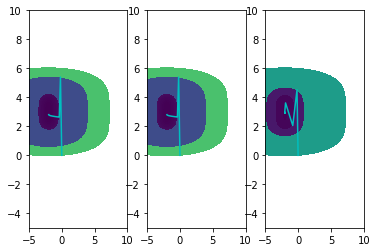

In [13]:
def f(x: np.array) -> float:
    return (x[0] + 2) ** 2 + (x[1] - 3) ** 4 - 10


def grad_f(x: np.array) -> np.array:
    return np.array([2 * (x[0] + 2), 4 * (x[1] - 3) ** 3])


draw_difference(
    f,
    gradient_descent(f, np.zeros(2), 50, 0.05),
    gradient_exp_descent(f, np.zeros(2), 50, 0.05, 0.003),
    gradient_descent_wolfe(f, grad_f, np.zeros(2), 50, 1e-5, 5e-4)
)

#### Функция Розенброка

In [14]:
def rosenbrock(x: np.array) -> float:
    a, b = 2, 5
    return (a - x[0]) ** 2 + b * (x[1] - x[0] ** 2) ** 2

def rosenbrock_grad(x):
    a, b = 2, 5
    return np.array([2 * (x[0] - a) + 4 * b * x[0] * (x[0] ** 2 - x[1]), 2 * b * (x[1] - x[0] ** 2)])

[1.94720701 3.78907173]
[1.80475339 3.2471369 ]
[2.11442196 4.47796217]


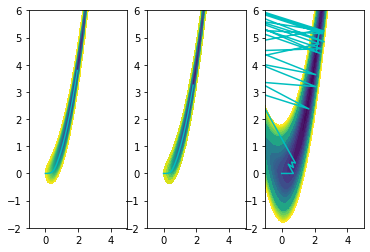

In [15]:
draw_difference(
    rosenbrock,
    gradient_descent(rosenbrock, np.zeros(2), 2000, 0.01),
    gradient_exp_descent(rosenbrock, np.zeros(2), 1000, 0.03, 0.003),
    gradient_descent_wolfe(rosenbrock, rosenbrock_grad, np.zeros(2), 1000, 1e-5, 5e-4),
    axis=[-1, 5, -2, 6]
)

В случае экспоненциального градиентного спуска необходимо в два раза меньше итераций

#### Функция Бута

In [16]:
def booth(x: np.array) -> float:
    return (x[0] + 2 * x[1] - 7) ** 2 + (2 * x[0] + x[1] - 5) ** 2


def booth_grad(x: np.array) -> np.array:
    return np.array([10 * x[0] + 8 * x[1] - 34, 8 * x[0] + 10 * x[1] - 38])

[1.13526798 2.86463312]
[1.04143404 2.95852361]
[1.09434919 3.09434919]


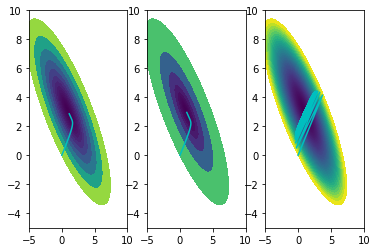

In [17]:
draw_difference(
    booth, 
    gradient_descent(booth, np.zeros(2), 100, 0.01),
    gradient_exp_descent(booth, np.zeros(2), 100, 0.02, 0.005),
    gradient_descent_wolfe(booth, booth_grad, np.zeros(2), 100, 1e-5, 5e-4),
)

#### Perturbed quadratic function

In [18]:
def perturbed(x: np.array) -> float:
    return x[0] ** 2 + 2 * (x[1] ** 2) + 1 / 100 * ((x[0] + x[1]) ** 2)

def perturbed_grad(x: np.array) -> np.array:
    return np.array([(101 * x[0] + x[1]) / 50, (x + 201 * x[1]) / 50])

[0.06531756 0.00779657]
[-0.01365951 -1.3656019 ]
[1.04143404 2.95852361]
[1.07076189 3.07076189]


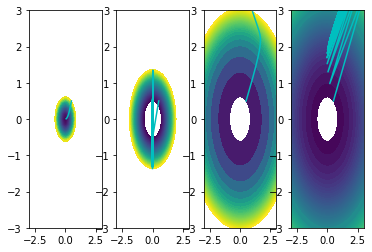

In [19]:
draw_difference(
    perturbed,
    gradient_descent(perturbed, np.array([0.5, 0.5]), 100, 0.01),
    gradient_descent(perturbed, np.array([0.5, 0.5]), 100, 0.5),
    gradient_exp_descent(booth, np.array([0.5, 0.5]), 100, 0.02, 0.005),
    gradient_descent_wolfe(booth, booth_grad, np.array([0.5, 0.5]), 100, 1e-5, 5e-4),
    axis=[-3, 3, -3, 3]
)

При $lr = 0.01$ сходится, при $lr = 0.5$ расходится